# Windup

In [1]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt

## Simple step response

In [2]:
num1 = [1]
den1 = [1, 7, 12, 0]

G = ct.tf(num1, den1)
print("Plant: ", G)

Plant:  
        1
------------------
s^3 + 7 s^2 + 12 s



In [3]:
# Controller
Kp = 50.4
Ti = 0.9069
Td = 0.2267

# PID actions
P = ct.tf([Kp], [1])
I = ct.tf([Kp], [Ti, 0])
D = ct.tf([Kp*Td, 0], [1])

Gc = P + I + D

print('PID controller: ',Gc)

PID controller:  
10.36 s^2 + 45.71 s + 50.4
--------------------------
         0.9069 s



In [4]:
# Closed-loop syste
sys = ct.feedback(Gc*G)

## Iterative step response

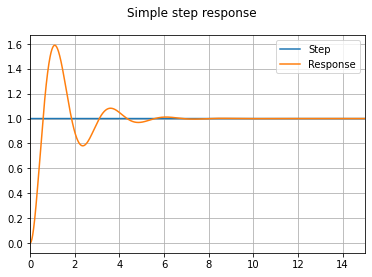

In [5]:
# Simulation parameters
tsim = 15
dt = 0.01

# Time and input vectors
t = np.arange(0, tsim, dt)
R = np.ones(len(t))
plt.plot(t, R, label = "Step")

# Response of the system
_, C1 = ct.forced_response(sys, t, R)
plt.plot(t, C1, label = "Response")

plt.xlim((0, tsim))
plt.legend()
plt.suptitle('Simple step response')
plt.grid()

In [6]:
# Convert the TF of the pplant to a space state model
Gss = ct.tf2ss(G)

# Initial conditions
xPre = np.zeros(len(G.pole()))

# Accumulated system response
C2 = np.zeros(len(t))

# Accumulated control signal
Uacc = np.zeros(len(t))

# Accumalated integral action
Iacc = np.zeros(len(t))

# Initialize the integral action and the error
I = 0
ePre = 0

# Saturation limits
lUp = 12
lDo = -12

for i, ti in enumerate(t):
    # Error
    e = R[i] - C2[i-1]
    
    # Controller
    P = Kp*e
    I = I + (Kp/Ti)*(e*dt)
    D = Kp*Td*(e - ePre)/dt
    
    V = P + I + D
    U = max(min(V, lUp), lDo)
    Uacc[i] = U
    
    # System response
    _, Ci, Xi = ct.forced_response(Gss, T = [ti-dt, ti], U = [U, U], X0 = xPre, return_x = True)
    
    # Update and accumulate the values
    C2[i] = np.squeeze(Ci[-1])
    xPre = np.squeeze(Xi[:,-1])
    Iacc[i] = I
    ePre = e
    

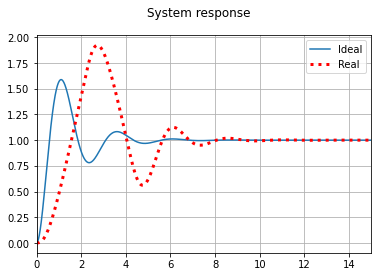

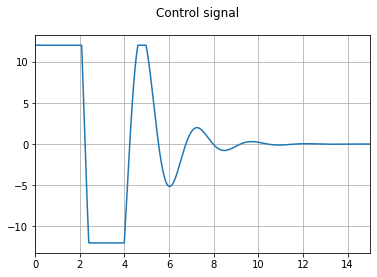

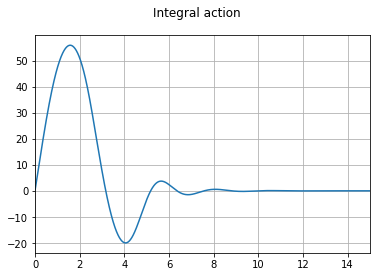

In [7]:
# System response
plt.plot(t, C1, label = "Ideal")
plt.plot(t, C2, 'r:', linewidth = 3,  label = "Real")
plt.xlim((0, tsim))
plt.legend()
plt.suptitle('System response')
plt.grid()

# Control signal
plt.figure()
plt.plot(t, Uacc)
plt.xlim((0, tsim))
plt.suptitle("Control signal")
plt.grid()

# Integral action
plt.figure()
plt.plot(t, Iacc)
plt.xlim((0, tsim))
plt.suptitle("Integral action")
plt.grid()

## Anti-windup: Conditional integration

In [8]:
# Convert the TF of the pplant to a space state model
Gss = ct.tf2ss(G)

# Initial conditions
xPre = np.zeros(len(G.pole()))

# Accumulated system response
C2 = np.zeros(len(t))

# Accumulated control signal
Vacc = np.zeros(len(t))

# Accumulated control signal (saturated)
Uacc = np.zeros(len(t))

# Accumalated integral action
Iacc = np.zeros(len(t))

# Initialize the integral action and the error
I = 0
ePre = 0

# Saturation limits
lUp = 12
lDo = -12

for i, ti in enumerate(t):
    # Error
    e = R[i] - C2[i-1]
    
    # Controller
    P = Kp*e
    
    # Conditional integration
    if Vacc[i-1] > lDo and Uacc[i-1] < lUp:
        I = I + (Kp/Ti)*(e*dt)
    
    D = Kp*Td*(e - ePre)/dt
    
    V = P + I + D
    Vacc[i] = V
    U = max(min(V, lUp), lDo)
    Uacc[i] = U
    
    # System response
    _, Ci, Xi = ct.forced_response(Gss, T = [ti-dt, ti], U = [U, U], X0 = xPre, return_x = True)
    
    # Update and accumulate the values
    C2[i] = np.squeeze(Ci[-1])
    xPre = np.squeeze(Xi[:,-1])
    Iacc[i] = I
    ePre = e
    

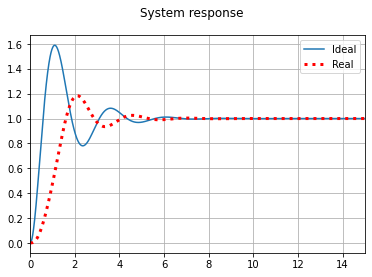

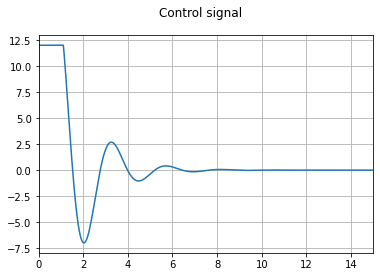

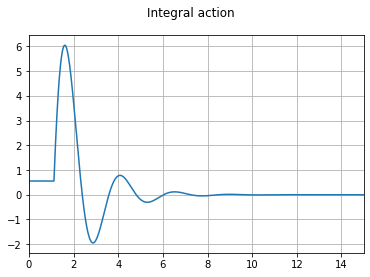

In [9]:
# System response
plt.plot(t, C1, label = "Ideal")
plt.plot(t, C2, 'r:', linewidth = 3,  label = "Real")
plt.xlim((0, tsim))
plt.legend()
plt.suptitle('System response')
plt.grid()

# Control signal
plt.figure()
plt.plot(t, Uacc)
plt.xlim((0, tsim))
plt.suptitle("Control signal")
plt.grid()

# Integral action
plt.figure()
plt.plot(t, Iacc)
plt.xlim((0, tsim))
plt.suptitle("Integral action")
plt.grid()

## Anti windup: Integral discharge

In [10]:
# Convert the TF of the pplant to a space state model
Gss = ct.tf2ss(G)

# Initial conditions
xPre = np.zeros(len(G.pole()))

# Accumulated system response
C2 = np.zeros(len(t))

# Accumulated control signal
Vacc = np.zeros(len(t))

# Accumulated control signal (saturated)
Uacc = np.zeros(len(t))

# Accumalated integral action
Iacc = np.zeros(len(t))

# Initialize the integral action and the error
I = 0
ePre = 0

# Saturation limits
lUp = 12
lDo = -12

# Discharge constant
Tt = np.sqrt(Ti*Td)

for i, ti in enumerate(t):
    # Error
    e = R[i] - C2[i-1]
    
    # Controller
    P = Kp*e
    
    #Integral discharge
    es = Uacc[i-1] - Vacc[i-1]
    I = I + dt*(Kp*e/Ti + es/Tt)
    
    D = Kp*Td*(e - ePre)/dt
    
    V = P + I + D
    Vacc[i] = V
    U = max(min(V, lUp), lDo)
    Uacc[i] = U
    
    # System response
    _, Ci, Xi = ct.forced_response(Gss, T = [ti-dt, ti], U = [U, U], X0 = xPre, return_x = True)
    
    # Update and accumulate the values
    C2[i] = np.squeeze(Ci[-1])
    xPre = np.squeeze(Xi[:,-1])
    Iacc[i] = I
    ePre = e
    

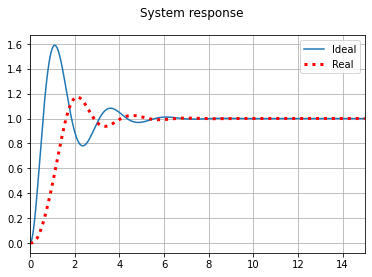

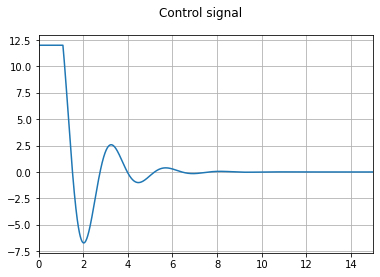

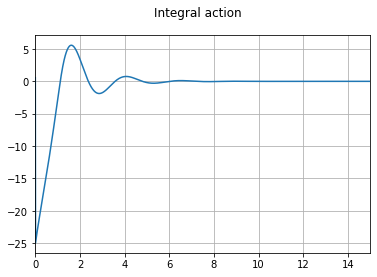

In [11]:
# System response
plt.plot(t, C1, label = "Ideal")
plt.plot(t, C2, 'r:', linewidth = 3,  label = "Real")
plt.xlim((0, tsim))
plt.legend()
plt.suptitle('System response')
plt.grid()

# Control signal
plt.figure()
plt.plot(t, Uacc)
plt.xlim((0, tsim))
plt.suptitle("Control signal")
plt.grid()

# Integral action
plt.figure()
plt.plot(t, Iacc)
plt.xlim((0, tsim))
plt.suptitle("Integral action")
plt.grid()